# Project: Trying to Predict Network Characteristics Using Attribute Data + Deep Learning

## Summary:
This notebook is a deep learning version of the 'Trying to Predict Network Characteristics Using Attribute Data + Machine Learning' project. The previous project had demonstrated that using machine learning models trained with attribute data to predict network characteristics did not result in satisfying model predictive power, which indicates the disparity between network characteristics and entity attributes. We will further examine this argument with more complicated model architectures, that is, we will use deep learning models to do the same thing to further confirm our argument.

## Contents:
1. Preparing Data
2. Regression: Predicting centrality with attributes
3. Regression: Predicting centrality with attributes + other centralities
4. Classification: Predicting network position with attributes
5. Classification: Predicting network position with attributes + centralities
6. Conclusion

##  Preparing Data

In [1]:
import pandas as pd

In [2]:
F = pd.read_csv(r"C:\Users\user\Documents\G03F_attribute_centrality_position.csv", index_col = 0)
B = pd.read_csv(r"C:\Users\user\Documents\G03B_attribute_centrality_position.csv", index_col = 0)

### cleaning

In [3]:
# add IPC column
F['IPC'] = 'G03F'
B['IPC'] = 'G03B'

# merge two df
df = pd.concat([B,F], axis = 0)

# fill all missing value with 0
df = df.fillna(0)

# for position_class column, change 0 to 'not included'
df.loc[df['position_class'] == 0,'position_class'] = 'not included'
# combine 'isolate nodes' and 'isolate community' to new class 'isolates'
df.loc[df['position_class'] == 'isolate node','position_class'] = 'isolates'
df.loc[df['position_class'] == 'isolate community','position_class'] = 'isolates'

# Transform the country column
allowed_countries = {'US', 'JP', 'TW', 'KR', 'CN'}
df['Country'] = df['國家'].apply(lambda x: x if x in allowed_countries else 'Others')

### dataset for each section

In [4]:
# select columns for section 2 'predicting centrality with attributes'
df2 = df.loc[:,['專利件數', '他人引證次數', '自我引證次數', '發明人數', '平均專利年齡', '活動年期', '時期', 'IPC', 'Country', 
                'pagerank']] # to be simple, we only choose pagerank as target centrality

# select columns for section 3 'predicting centrality with attributes and other centralities'
df3 = df.loc[:,['專利件數', '他人引證次數', '自我引證次數', '發明人數', '平均專利年齡', '活動年期', '時期', 'IPC', 'Country', 
                'indegree', 'closeness', 'betweenness', 'harmonic', 'eigenvector', 'katz', 'laplacian', 
                'pagerank']] # pagerank centrality is target

# select columns for section 4 'predicting network position with attributes'
df4 = df.loc[:,['專利件數', '他人引證次數', '自我引證次數', '發明人數', '平均專利年齡', '活動年期', '時期', 'IPC', 'Country', 
                'position_class']] # position_class is target

# select columns for section 5 'predicting network position with attributes and centralities'
df5 = df.loc[:,['專利件數', '他人引證次數', '自我引證次數', '發明人數', '平均專利年齡', '活動年期', '時期', 'IPC', 'Country', 
                'indegree', 'closeness', 'betweenness', 'harmonic', 'eigenvector', 'katz', 'pagerank', 'laplacian', 
                'position_class']] # position_class is target

### preprocessing

1. define features and target
2. train test split
3. numerical features pipeline: scaling, polynomial feature generation, intitial feature selection
4. categorical features pipeline: one-hot encoding
5. all features pipeline: feature selection and feauture extraction (PCA)
6. fit_transform x_train with pipeline
7. transform x_test with the same pipeline
8. return X_train_processed, X_test_processed, y_train, y_test

The dataset we are using is small, only 551 data points. The following model trainings will control number of features to be 20 in each section, so that evaluation metrics could be compared between each section (same train, val, test dataset size; same number of features and preprocessing).

In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [6]:
# define preprocessing function for regression task
def preprocessing_20features_traintestsplit(df):
    # Define features and target
    X = df.drop(df.columns[-1], axis=1)
    y = df.iloc[:,-1]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)

    # Identify numerical and categorical columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Preprocessing for numerical data
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),  # Polynomial features
        ('variance_threshold', VarianceThreshold(threshold=0.1)),  # Initial feature selection
    ])

    # Preprocessing for categorical data
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore')),  # One-hot encoding
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

    # Full pipeline including feature selection and extraction
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('select_k_best', SelectKBest(score_func=f_regression, k=30)),  # Feature selection on transformed features
        ('pca', PCA(n_components=20)),  # Feature extraction
    ])

    # Fit and transform the training data
    X_train_processed = full_pipeline.fit_transform(X_train, y_train)
    X_test_processed = full_pipeline.transform(X_test)

    # Output the processed features for verification
    print("Processed training features shape:", X_train_processed.shape)
    print("Processed testing features shape:", X_test_processed.shape)

    return X_train_processed, X_test_processed, y_train, y_test

In [7]:
# define preprocessing function for classification task
def preprocessing_20features_multiclasstarget_traintestsplit(df):
    # Define features and target
    X = df.drop(df.columns[-1], axis=1)
    y = df.iloc[:,-1]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)

    # Identify numerical and categorical columns
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Preprocessing for numerical data
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),  # Polynomial features
        ('variance_threshold', VarianceThreshold(threshold=0.1)),  # Initial feature selection
    ])

    # Preprocessing for categorical data
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore')),  # One-hot encoding
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

    # Full pipeline including feature selection and extraction
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('select_k_best', SelectKBest(score_func=f_classif, k=30)),  # Feature selection on transformed features
        ('pca', PCA(n_components=20)),  # Feature extraction
    ])

    # Fit and transform the training data
    X_train_processed = full_pipeline.fit_transform(X_train, y_train)
    X_test_processed = full_pipeline.transform(X_test)

    # One-hot encode the target variable
    onehot_encoder = OneHotEncoder(sparse_output = False)
    y_train_encoded = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test_encoded = onehot_encoder.transform(y_test.values.reshape(-1, 1))
    
    # Output the processed features for verification
    print("Processed training features shape:", X_train_processed.shape)
    print("Processed testing features shape:", X_test_processed.shape)
    print("Encoded training target shape:", y_train_encoded.shape)
    print("Encoded testing target shape:", y_test_encoded.shape)

    return X_train_processed, X_test_processed, y_train_encoded, y_test_encoded

## Regression

We will use pagerank centrality as target:

|Centrality|Description|
|---|---|
|Indegree|Indegree centrality of a node is the number of neighbors that had chosen this node. It is the simplest centrality indicator of a node in a network.|
|Eigenvector|Eigenvector centrality computes the centrality for a node by adding the centrality of its neighbors. It reflects the importance of node i not just by counting how many neighbors does it has, but also take i's neighbors' importance into account. It could be seen as a more sophisticated and improved centrality indicator compared with indegree centrality.|
|Pagerank|Originally, it was developed by Google to rank webpages. Pagerank could be seen as a further improvement based on eigenvector centrality. Like eigenvector centrality,  Pagerank also consider a node's importance based on it's neighbors, but, unlike eigenvector centrality, it further considers each neighbors' number of out degree to weight the contribution of each neighbor's importance to the focus node's importance.|

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

import matplotlib.pyplot as plt

### Defining Model

In [ ]:
# define regression task model
def create_regression_model(hidden_layers=1, neurons=32, dropout_rate=0.5, l2_reg=0.01, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(20,))) # Input layer
    model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
    model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['r2_score'])
    return model

In [ ]:
# adopt early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
# wrap the model
reg_model = KerasRegressor(model = create_regression_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping])

In [ ]:
# hyperparameter dictionary for grid search
param_grid = {
    'model__hidden_layers': [8,12,16],
    'model__neurons': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__l2_reg': [0.001, 0.01],
    'model__learning_rate': [0.01, 0.05]
}

In [19]:
def train_regression_model(df):
    # train test split
    X_train, X_test, y_train, y_test = preprocessing_20features_traintestsplit(df)
    
    # perform grid search over model
    grid = GridSearchCV(estimator = reg_model, param_grid = param_grid, cv = 3, scoring = 'r2', n_jobs = -1)
    grid_result = grid.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_result.best_params_}")
    print(f"Best cross-validation R2 score: {grid_result.best_score_}")

    # rebuild and train the best model
    best_params = grid_result.best_params_
    best_model = create_regression_model(hidden_layers=best_params['model__hidden_layers'],
                                      neurons=best_params['model__neurons'],
                                      dropout_rate=best_params['model__dropout_rate'],
                                      l2_reg=best_params['model__l2_reg'],
                                      learning_rate=best_params['model__learning_rate'])

    history = best_model.fit(X_train, y_train, epochs = 100, batch_size = 10, 
                         verbose = 0, callbacks = [early_stopping], 
                         validation_split = 0.2)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation Metrics values
    plt.plot(history.history['r2_score'])
    plt.plot(history.history['val_r2_score'])
    plt.title('Model R2')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

    # evaluate best model on the test set
    test_loss, test_metrics = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {test_loss}")
    print(f"Test R2: {test_metrics}")

### Predicting centrality with attributes

Processed training features shape: (440, 20)
Processed testing features shape: (111, 20)


C:\Users\user\miniconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'model__dropout_rate': 0.3, 'model__hidden_layers': 8, 'model__l2_reg': 0.001, 'model__learning_rate': 0.01, 'model__neurons': 32}
Best cross-validation R2 score: 0.014641037558914919


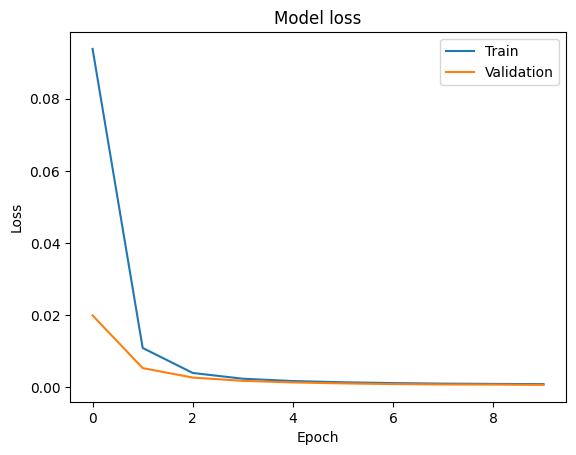

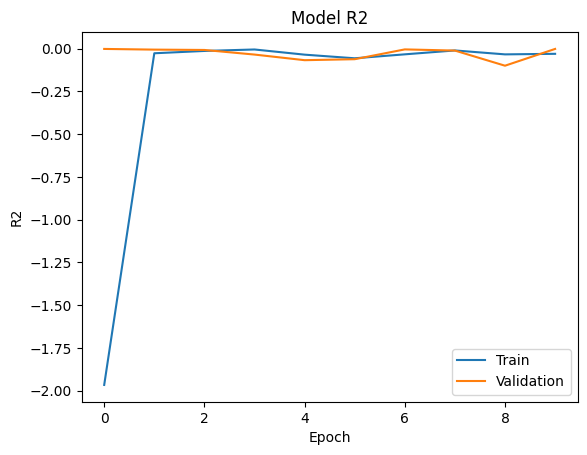

Test loss: 0.02006257139146328
Test R2: 0.0016199946403503418


In [36]:
train_regression_model(df2)

### Predicting centrality with attributes + other centralities

Processed training features shape: (440, 20)
Processed testing features shape: (111, 20)


C:\Users\user\miniconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'model__dropout_rate': 0.5, 'model__hidden_layers': 8, 'model__l2_reg': 0.01, 'model__learning_rate': 0.01, 'model__neurons': 64}
Best cross-validation R2 score: 0.053735366130228855


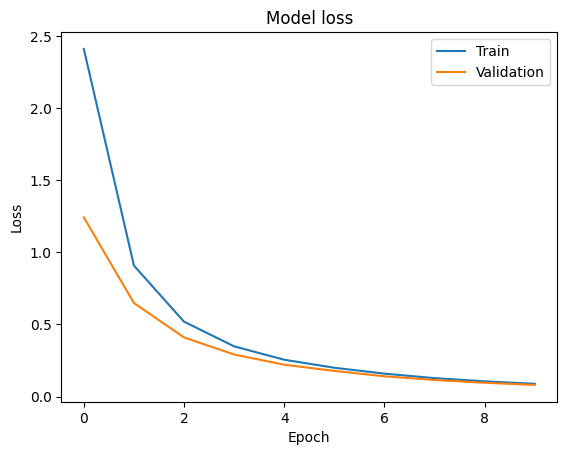

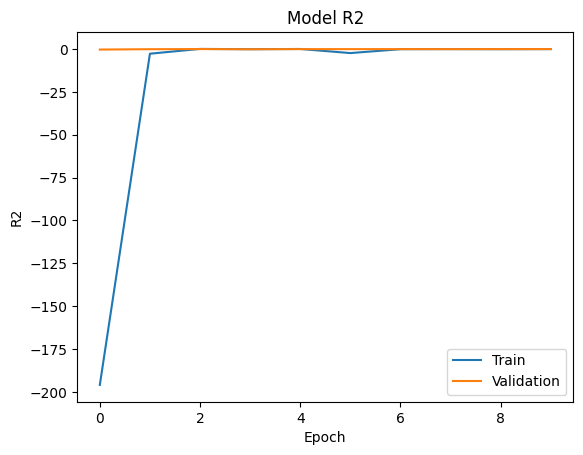

Test loss: 1.2419099807739258
Test R2: -0.2772763967514038


In [40]:
train_regression_model(df3)

## Classification:

Network position is a multi-class target variable:

|class|description|
|---|---|
|largest community|nodes locates in the largest weakly connected component and also locates in the largest community defined by edge betweenness partition community detection|
|other community|nodes locates in the largest weakly connected component but does not locate in the largest community defined by edge betweenness partition community detection|
|isolates|nodes that does not locate in the largest weakly connected component, including isolated communities and isolated nodes|
|not included|nodes that does not appear in the network|

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor, KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform

import matplotlib.pyplot as plt

### Defining Model

In [9]:
# define classification task model
def create_classification_model(hidden_layers=1, neurons=32, dropout_rate=0.5, l2_reg=0.01):
    model = Sequential()
    model.add(Input(shape=(20,))) # Input layer
    model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
    model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# adopt early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [11]:
# wrap the model
class_model = KerasClassifier(model = create_classification_model, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping],
                             optimizer = 'adam', optimizer__learning_rate=0.01)

In [12]:
# hyperparameter dictionary for grid search
param_grid = {
    'model__hidden_layers': [8,12,16],
    'model__neurons': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__l2_reg': [0.001, 0.01],
    'optimizer__learning_rate': [0.01, 0.05]
}

In [13]:
# define classification task retrain model
def create_classification_retrain_model(hidden_layers=1, neurons=32, dropout_rate=0.5, l2_reg=0.01, learning_rate = 0.001):
    model = Sequential()
    model.add(Input(shape=(20,))) # Input layer
    model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
    model.add(Dropout(dropout_rate))
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), kernel_initializer=GlorotUniform()))
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def train_classification_model(df):
    # train test split
    X_train, X_test, y_train, y_test = preprocessing_20features_multiclasstarget_traintestsplit(df)
    
    # perform grid search over model
    grid = GridSearchCV(estimator = class_model, param_grid = param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
    grid_result = grid.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_result.best_params_}")
    print(f"Best cross-validation Accuracy: {grid_result.best_score_}")

    # rebuild and train the best model
    best_params = grid_result.best_params_
    best_model = create_classification_retrain_model(hidden_layers=best_params['model__hidden_layers'],
                                      neurons=best_params['model__neurons'],
                                      dropout_rate=best_params['model__dropout_rate'],
                                      l2_reg=best_params['model__l2_reg'],
                                      learning_rate=best_params['optimizer__learning_rate'])

    history = best_model.fit(X_train, y_train, epochs = 100, batch_size = 10, 
                         verbose = 0, callbacks = [early_stopping], 
                         validation_split = 0.2)

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot training & validation Metrics values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

    # evaluate best model on the test set
    test_loss, test_metrics = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {test_loss}")
    print(f"Test Accuracy: {test_metrics}")

### Predicting network position with attributes

Processed training features shape: (440, 20)
Processed testing features shape: (111, 20)
Encoded training target shape: (440, 4)
Encoded testing target shape: (111, 4)
Best parameters found: {'model__dropout_rate': 0.3, 'model__hidden_layers': 12, 'model__l2_reg': 0.001, 'model__neurons': 64, 'optimizer__learning_rate': 0.05}
Best cross-validation Accuracy: 0.5909359177460939


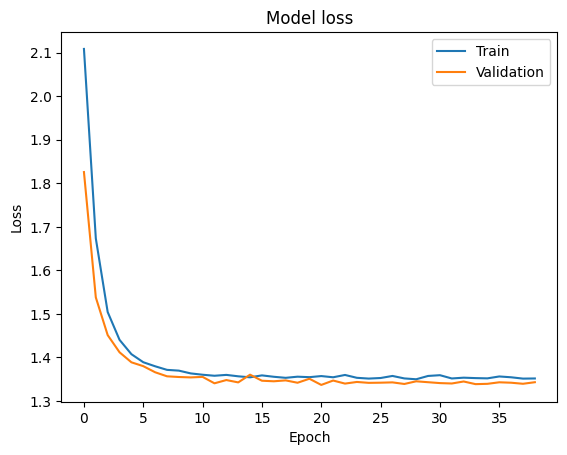

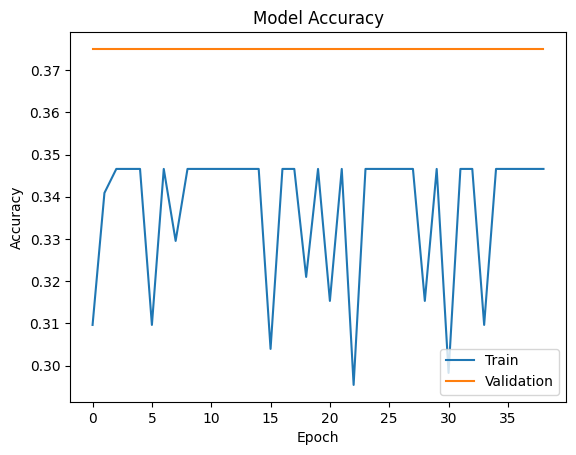

Test loss: 1.351886510848999
Test Accuracy: 0.315315306186676


In [77]:
train_classification_model(df4)

### Predicting network position with attributes + centralities

Processed training features shape: (440, 20)
Processed testing features shape: (111, 20)
Encoded training target shape: (440, 4)
Encoded testing target shape: (111, 4)
Best parameters found: {'model__dropout_rate': 0.5, 'model__hidden_layers': 8, 'model__l2_reg': 0.01, 'model__neurons': 64, 'optimizer__learning_rate': 0.05}
Best cross-validation Accuracy: 0.7816606094492592


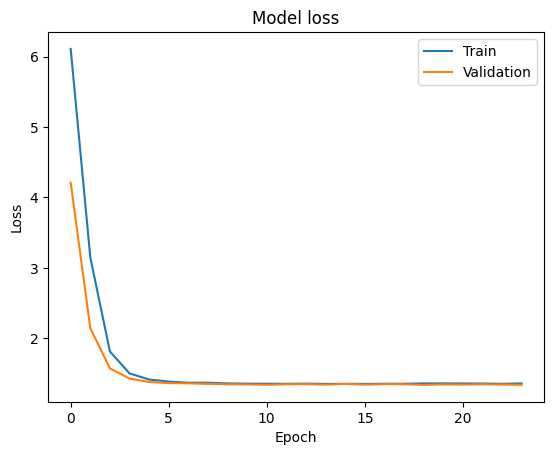

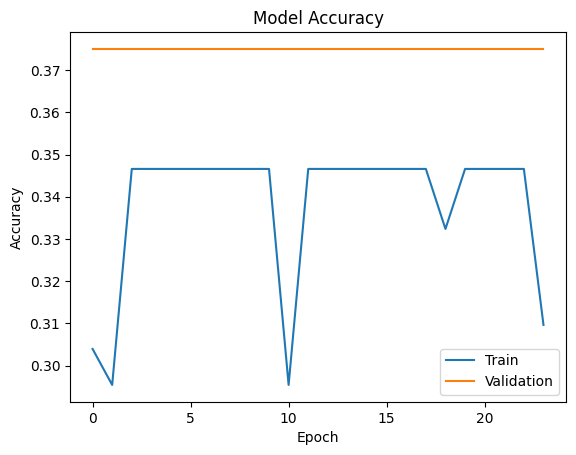

Test loss: 1.3533434867858887
Test Accuracy: 0.315315306186676


In [15]:
train_classification_model(df5)

## Conclusion

While the deep learning model demonstrated improved validation set metrics when incorporating network characteristics into the dataset, the results were not as striking as those observed in its machine learning counterpart. Specifically, test set metrics for both regression and classification tasks did not show significant improvements. This limitation may be attributed to the small size of the dataset, which can lead to overfitting when attempting to optimize validation set metrics by scaling the neural network. Furthermore, the regression task validation set metrics were unsatisfactory, indicating that the model was already overfitting, even with suboptimal validation set performance. In the classification task sections, although validation set metrics improved, overfitting remained a significant challenge, and applying various regularization methods failed to enhance test set metrics.
